In [ ]:
# link to download data
#https://www.kaggle.com/code/aashidutt3/eda-pga-tour-golf-data/notebook?select=ASA+All+PGA+Raw+Data+-+Tourn+Level.csv

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.utils import resample
from scipy.stats import spearmanr
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score
import warnings
warnings.filterwarnings('ignore')

df = pd.read_csv('pga_raw_data.csv')

cols = ['Finish', 'sg_ott', 'sg_app', 'sg_arg', 'sg_putt']
df = df[cols]
df = df[df['Finish'].notna()]

bad_finishes = ['CUT', 'W/D', 'DQ', 'WD', 'MC', 'DNS', 'DSQ', 'NA', 'nan', '']
df = df[~df['Finish'].isin(bad_finishes)]

df['Finish'] = df['Finish'].astype(str).str.replace('T', '', regex=False)
df = df[df['Finish'].str.isnumeric()]
df['Finish'] = df['Finish'].astype(int)

df = df.dropna(subset=['sg_ott', 'sg_app', 'sg_arg', 'sg_putt'])


In [2]:
df

,Finish,sg_ott,sg_app,sg_arg,sg_putt
0,32,0.86,-0.08,-0.13,0.20
1,18,0.18,0.31,0.75,0.36
6,26,-0.12,-1.32,0.74,2.05
7,26,0.48,1.84,-0.01,-0.96
8,67,-1.04,2.00,-1.79,-0.82
...,...,...,...,...,...
36747,49,-0.39,0.26,-0.27,0.66
36748,33,0.66,-0.37,0.36,0.09
36749,42,-0.64,0.54,0.04,0.55
36750,4,0.28,1.23,0.76,-0.02


# The impact of Strokes Gained Metrics on PGA Tour Finishing Position

## Jim Bellas

# 1. Introduction

In professional golf, understanding what aspects of the game most significantly impact tournament performance is crucial for players looking to improve their results. The introduction of "strokes gained" metrics has revolutionized golf analytics by providing more precise measurements of performance across different aspects of the game. This analysis explores how various strokes gained categories relate to tournament finishing positions, with the goal of identifying which aspects of golf performance most strongly predict success.



#2. Background

### Strokes Gained Metrics
Strokes gained is a statistical approach developed to measure player performance relative to the field in specific aspects of golf. Unlike traditional statistics like fairways hit or greens in regulation, strokes gained provides a more nuanced understanding of performance by comparing a player's shots to the average performance of other tour professionals in similar situations.

The four main strokes gained categories analyzed in this study are:

1. Strokes Gained: Off the Tee (sg_ott) - Measures performance from the tee box, including both distance and accuracy.

2. Strokes Gained: Approach (sg_app) - Quantifies performance on approach shots to the green, typically from the fairway or rough.

3. Strokes Gained: Around the Green (sg_arg) - Evaluates short game performance on shots near the green but not on the putting surface.

4. Strokes Gained: Putting (sg_putt) - Measures putting performance on the green.

A positive strokes gained value indicates performance better than the field average, while negative values represent performance below average. For example, a strokes gained: putting value of +2.0 means a player gained two strokes on the field with their putting in that round.

Example: A player tees off and hits the ball 290 yards in the fairway. On that course the average tour player hits it 280 yards in the fairway. From 280 yards, the average player finishes the hole in 2.88 strokes while from 290 yards the average player finishes the hole in 2.76 strokes. This means that the player has gained 0.12 strokes off the tee.

### Tournament Finish Position
In golf tournaments, players are ranked by their total score relative to par, with the lowest total score winning. The "Finish" variable represents a player's final standing in a tournament, with lower numbers indicating better performance (1st place being the winner).

#3. Analysis of Strokes Gained Categories


sg_ott: Correlation with Finish = -0.358 (p=0)
sg_app: Correlation with Finish = -0.483 (p=0)
sg_arg: Correlation with Finish = -0.293 (p=0)
sg_putt: Correlation with Finish = -0.435 (p=0)

Regression coefficients (impact on finish position):
sg_ott: -14.30
sg_app: -13.76
sg_arg: -14.19
sg_putt: -13.89


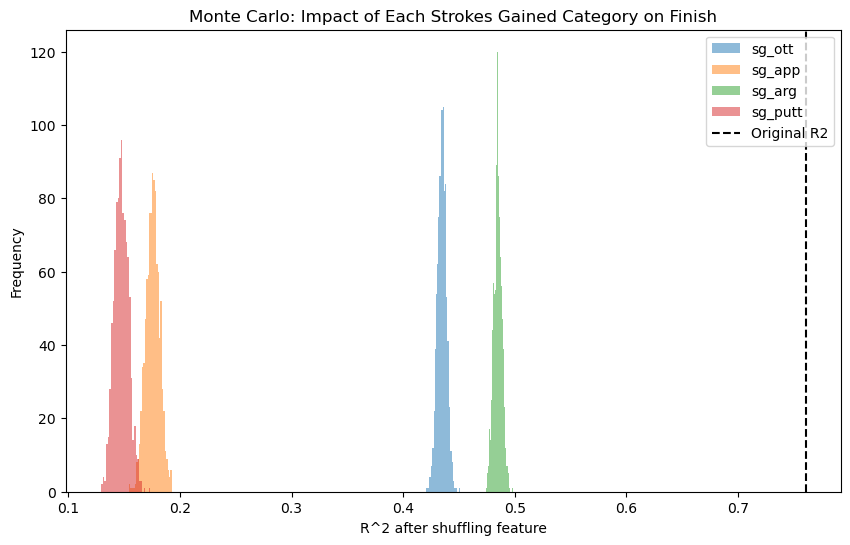

In [3]:
# Correlation analysis

for col in ['sg_ott', 'sg_app', 'sg_arg', 'sg_putt']:
    corr, pval = spearmanr(df[col], df['Finish'])
    print(f"{col}: Correlation with Finish = {corr:.3f} (p={pval:.3g})")

print("")

# Regression analysis
X = df[['sg_ott', 'sg_app', 'sg_arg', 'sg_putt']]
y = df['Finish']
reg = LinearRegression()
reg.fit(X, y)
print("Regression coefficients (impact on finish position):")
for name, coef in zip(X.columns, reg.coef_):
    print(f"{name}: {coef:.2f}")

# Monte Carlo
n_sim = 1000
results = {col: [] for col in X.columns}
r2_orig = reg.score(X, y)

for col in X.columns:
    for _ in range(n_sim):
        X_sim = X.copy()
        X_sim[col] = np.random.permutation(X_sim[col].values)
        r2 = reg.score(X_sim, y)
        results[col].append(r2)

# Plotting
plt.figure(figsize=(10,6))
for col in X.columns:
    plt.hist(results[col], bins=30, alpha=0.5, label=col)
plt.axvline(r2_orig, color='k', linestyle='--', label='Original R2')
plt.xlabel('R^2 after shuffling feature')
plt.ylabel('Frequency')
plt.title('Monte Carlo: Impact of Each Strokes Gained Category on Finish')
plt.legend()
plt.show()


## Correlation Analysis

#### Results
- sg_app: Correlation with Finish = -0.483

- sg_putt: Correlation with Finish = -0.435

- sg_ott: Correlation with Finish = -0.358

- sg_arg: Correlation with Finish = -0.293




#### Interpretation of results:

The negative direction of each correlation result indicated that the finish position gets lower as strokes gained increases. This makes sence as a lower finish position indicates a better outcome.

Statistical significance: All p-values are 0 (or extremely close), meaning these relationships are statistically significant.

#### Takeaway:
Players who are better in any strokes gained category tend to finish higher, but approach shots and putting are most strongly associated with better finishes.

---


## Regression Analysis

#### Results

Regression coefficients:

- sg_ott: -14.30

- sg_arg: -14.19

- sg_putt: -13.89

- sg_app: -13.76




#### Interpretation of Results:

All coefficients are negative, consistent with the correlations. Increasing strokes gained in any category predicts a better (lower) finish position.

Each coefficient represents the expected change in finish position for a 1-unit increase in that strokes gained category, holding the others constant.

For example, if a player improves their SG Off The Tee by 1, their predicted finish position improves by about 14 places.


#### Takeaway:
Improvement in any strokes gained category has a large, positive impact on finish position, with all four categories contributing similarly when considered together.

---

## Monte Carlo Analysis

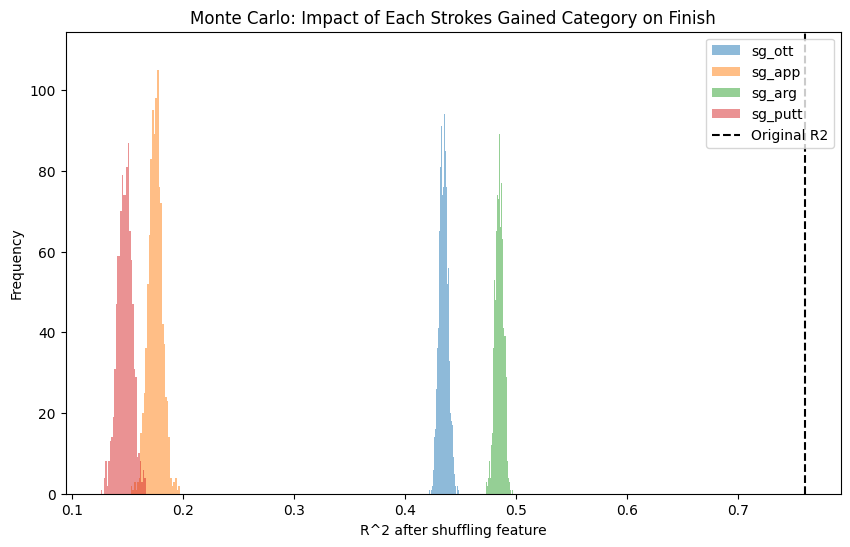

#### Plot Interpretation
Each colored histogram shows the distribution of R² values when one category is shuffled 1000 times.

The vertical dashed line represents the R² of the original, unshuffled model has an R² of about 0.76.

#### Key Observations
All histograms are far to the left of the original R² line, meaning that shuffling any one categories causes a big decrease in model performance. This shows that each strokes gained category is important for predicting finish position.

#### Relative importance:
1. Putting: ~ 0.16
2. Approach: ~ 0.20
3. Off The Tee	Higher: ~ 0.42
4. Around The Green:	~ 0.48

Approach and putting are the most critical. Removing their information causes the biggest loss in model accuracy. Off the tee and around the green still matter, but less so than approach and putting.

This analysis supports the findings in the correlation analysis that better putting and approach strokes gained are more important to finishing in a better position.   


# 4. Elite Player Analysis

Average Finish Position for Top 1% in Each SG Category:
Off the Tee: Avg Finish = 16.59 (n=173)
Approach: Avg Finish = 13.97 (n=170)
Around the Green: Avg Finish = 25.13 (n=167)
Putting: Avg Finish = 16.17 (n=174)


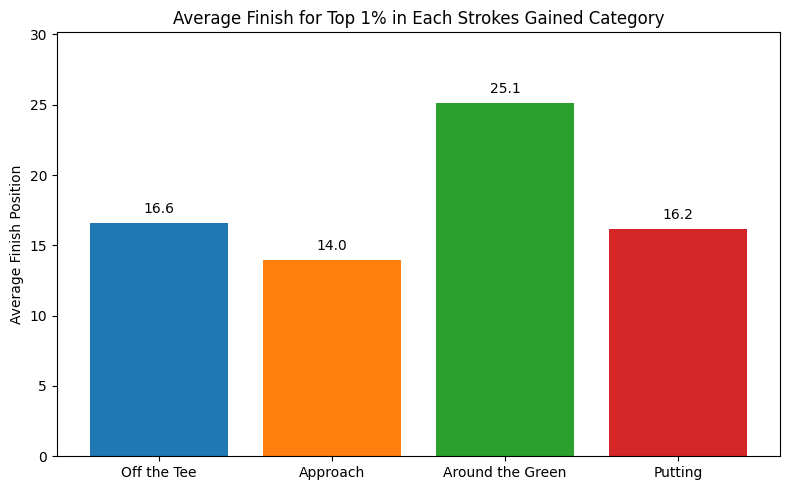

Average Strokes Gained for Top 1% Tournament Finishers:
Off the Tee: 0.68
Approach: 1.31
Around the Green: 0.43
Putting: 1.24


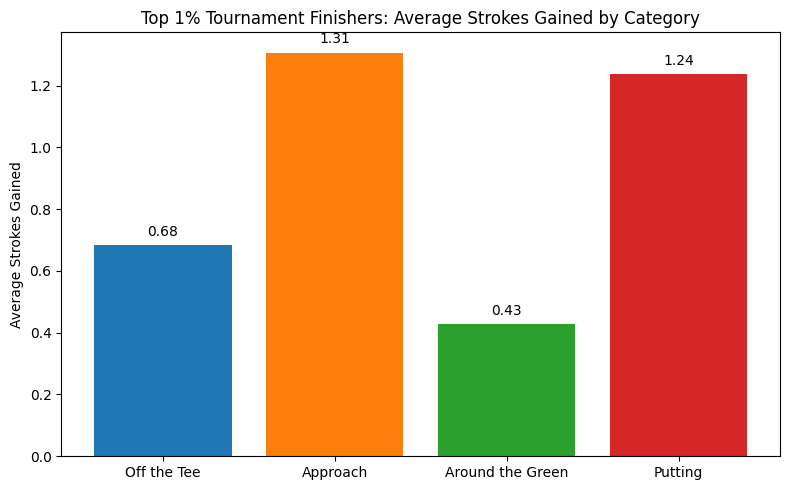

In [ ]:
sg_cols = {
    'Off the Tee': 'sg_ott',
    'Approach': 'sg_app',
    'Around the Green': 'sg_arg',
    'Putting': 'sg_putt'
}

df = df[df['Finish'].notna()]
df = df[~df['Finish'].astype(str).isin(['CUT', 'W/D', 'DQ', 'WD', 'MC', 'DNS', 'DSQ', 'NA', 'nan', ''])]
df['Finish'] = df['Finish'].astype(str).str.replace('T', '', regex=False)
df = df[df['Finish'].str.isnumeric()]
df['Finish'] = df['Finish'].astype(int)

for col in sg_cols.values():
    df = df[df[col].notna()]

results = {}

for label, col in sg_cols.items():
    threshold = df[col].quantile(0.99)
    top1 = df[df[col] >= threshold]
    avg_finish = top1['Finish'].mean()
    n_players = len(top1)
    results[label] = {'Avg Finish': avg_finish, 'Count': n_players}

print("Average Finish Position for Top 1% in Each SG Category:")
for label, stats in results.items():
    print(f"{label}: Avg Finish = {stats['Avg Finish']:.2f} (n={stats['Count']})")


labels = list(results.keys())
avg_finishes = [results[label]['Avg Finish'] for label in labels]

plt.figure(figsize=(8,5))
bars = plt.bar(labels, avg_finishes, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'])
plt.ylabel('Average Finish Position')
plt.title('Average Finish for Top 1% in Each Strokes Gained Category')
plt.ylim(0, max(avg_finishes)*1.2)
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.5, f"{yval:.1f}", ha='center', va='bottom')
plt.tight_layout()
plt.show()

df = df[df['Finish'].notna()]
df = df[~df['Finish'].astype(str).isin(['CUT', 'W/D', 'DQ', 'WD', 'MC', 'DNS', 'DSQ', 'NA', 'nan', ''])]
df['Finish'] = df['Finish'].astype(str).str.replace('T', '', regex=False)
df = df[df['Finish'].str.isnumeric()]
df['Finish'] = df['Finish'].astype(int)

sg_cols = {
    'Off the Tee': 'sg_ott',
    'Approach': 'sg_app',
    'Around the Green': 'sg_arg',
    'Putting': 'sg_putt'
}
for col in sg_cols.values():
    df = df[df[col].notna()]

finish_threshold = df['Finish'].quantile(0.01)
top_finishers = df[df['Finish'] <= finish_threshold]

results = {}
for label, col in sg_cols.items():
    avg_sg = top_finishers[col].mean()
    results[label] = avg_sg

print("Average Strokes Gained for Top 1% Tournament Finishers:")
for label, avg_sg in results.items():
    print(f"{label}: {avg_sg:.2f}")

import matplotlib.pyplot as plt
labels = list(results.keys())
values = [results[label] for label in labels]

plt.figure(figsize=(8,5))
bars = plt.bar(labels, values, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'])
plt.ylabel('Average Strokes Gained')
plt.title('Top 1% Tournament Finishers: Average Strokes Gained by Category')
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.02, f"{yval:.2f}", ha='center', va='bottom')
plt.tight_layout()
plt.show()





## Examining Elite Golfers Abilitities
*An "Elite" golfer referrs to the top 1% of golfers in the dataset from 2015 to 2022.*

<br>

#### Finish Position of Elite Golfers
This first analysis identifies players who excel in a specific strokes gained category and examines how well they finish in tournaments on average:

- Approach: Average finish position of 13.97

- Putting: Average finish position of 16.17

- Off the Tee: Average finish position of 16.59

- Around the Green: Average finish position of 25.13

<br>

#### Strokes Gained of Elite Golfers
The second analysis flips the perspective by examining the strokes gained profile of the top 1% tournament finishers. This reveals how elite tournament performers achieve their success across the four skills:

- Approach: Average of 1.31 strokes gained

- Putting: Average of 1.24 strokes gained

- Off the Tee: Average of 0.68 strokes gained

- Around the Green: Average of 0.43 strokes gained


#### Implication
The consistency between overall elite golfers and elite golfers in each strokes gained category strengthens our confidence in the findings. Both methods point to the same conclusion; approach shots and putting have been the most important skill for elite tournament golfers.


# 6. Conclusion

This analysis provides compelling evidence that while all aspects of golf performance contribute to tournament success, approach shots and putting have the strongest relationship with finishing position. Players who excel in these areas typically achieve better tournament results than those who primarily excel in off-the-tee or around-the-green performance.

The findings suggest several key implications for professional golfers and coaches:

Average players should consider allocating more practice time to approach shots and putting, as these skills appear to have the strongest relationship with tournament success.

For players looking to improve their tournament performance, focusing on gaining strokes with approach shots might yield the greatest benefits.

The consistency of results across different analytical methods (correlation, regression, Monte Carlo analysis, and elite player analysis) strengthens confidence in the most important skill to master being approach shots.

# References

1. Strokes Gained Explanation: https://shotscope.com/blog/practice-green/stats-and-data/understanding-strokes-gained/


2. Background on shot link data: https://golf.com/gear/pga-tour-shotlink-data-game-changer-you-can-bet-on-it/


3. Shots Gained data: https://www.kaggle.com/code/aashidutt3/eda-pga-tour-golf-data/code?select=ASA+All+PGA+Raw+Data+-+Tourn+Level.csv
